### 数据库操作
从数据库中导入POI数据

In [144]:
import psycopg2

con = psycopg2.connect(database="prato", user="postgres", password="1218", host="127.0.0.1", port="5432")

# 找出所有含有功能信息的POI
cur = con.cursor()
cur.execute("select * from function where type <> \'null\'")
#cur.execute("select * from function where is_Chinese = True")
rows = cur.fetchall()

print("Database opened successfully")
print("Data Len = ", len(rows))
cur.close()
con.close()

Database opened successfully
Data Len =  10414


### GeoMath
提供坐标与经纬度之间的相互转换

In [2]:
# 基本静态变量
center = [43.878150000000005, 11.083850000000002]
equatorial_radius = 6378137.0
polar_radius = 6356752.3
earth_radius = 6367908.065252312
map_ratio = 0.7211005671900231

# 方法
import math

def calcEarthRadius(lat):
    global earth_radius
    global equatorial_radius
    global polar_radius
    lat = math.radians(lat)
    
    a = equatorial_radius
    b = polar_radius

    ta = a * math.cos(lat)
    tb = b * math.sin(lat)

    earth_radius = math.sqrt((ta * a * ta * a + tb * b * tb * b) / (ta * ta + tb * tb))


def haversineDistance(lat1, lng1, lat2, lng2):
    calcEarthRadius((lat1+lat2)/2)

    dlat = math.radians(lat2 - lat1)
    dlng = math.radians(lng2 - lng1)

    a = math.sin(dlat/2)*math.sin(dlat/2) + math.sin(dlng/2)*math.sin(dlng/2)*math.cos(lat1)*math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))


def latLngToXY(lat, lng):
    global map_ratio
    dist = haversineDistance(lat, lng, center[0], center[1])
    y = math.radians(lat - center[0])
    xp = math.radians(lng - center[1])
    
    if(map_ratio == 0.0):
        yp = math.log(math.tan(math.pi / 4.0 + math.radians(lat) / 2.0)) - math.log(math.tan(math.pi/4.0 + math.radians(center[0]) / 2.0))
        map_ratio = y/yp

    x = map_ratio * xp
    
    return earth_radius * x, earth_radius * y
    

def xyToLatLng(x, y):
    global map_ratio
    lat = math.degrees(y / earth_radius) + center[0]
    x /= map_ratio
    lng = math.degrees(x / earth_radius) + center[1]

    return lat, lng

# 计算地球坐标
calcEarthRadius(center[0])


# 检查经纬度转换是否正确
print(earth_radius)
x, y = latLngToXY(43.831, 11.0202)
print(x, y)
x, y = latLngToXY(43.9253, 11.1475)
print(x, y)

6367908.065252312
-5101.160603307125 -5240.303600544768
5101.146521771683 5240.289134910398


### 数据转换
将数据库中得到的row数据整理为类和对象列表

In [143]:
class Gpoi:
    def __init__(self, placeid, x, y, funtion):
        self.placeid = placeid
        self.x = x
        self.y = y
        self.type = funtion
        
    def __lt__(self, other):
        return self.x < other.x
    

colorDict = {
    'transport': (102, 102, 255),
    'government': (102, 153, 255),
    'health': (102, 204, 255),
    'education': (102, 255, 255),
    'religious': (102, 255, 204),
    'civic': (102, 255, 153),
    'sport': (102, 255, 102),
    'service': (153, 255, 102),
    'beauty': (204, 255, 102),
    'entertain': (255, 255, 102),
    'retail': (255, 204, 102),
    'hotel': (255, 153, 102),
    'food': (255, 102, 102)
}

In [152]:
p = []
for row in rows:
    x, y = latLngToXY(row[1], row[2])
    if('null' in row[7]):
        continue
    p.append(Gpoi(row[0].strip(), x, y, row[7].strip()))

p = sorted(p)

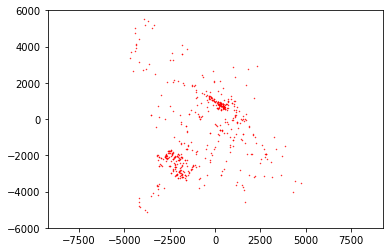

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.array([q.x for q in p])
y = np.array([q.y for q in p])
plt.scatter(x, y, s=0.2, c='r')

plt.axis("equal")
plt.ylim(-6000, 6000)

plt.show()

In [229]:
import copy
import bisect
import uuid
from PIL import Image, ImageDraw

step = 10
num = 9
y_size = step*num   #90
x_size = y_size*3   #270

def rangeAABB(pt, rang):
    t = copy.deepcopy(pt)

    ox, oy = t.x, t.y
    t.x -= rang
    left = bisect.bisect_left(p, t)
    t.x += rang*2
    right = bisect.bisect_left(p, t)

    partP = p[left:right]

    ppartP = []
    for q in partP:
        if (q.y < oy+rang and q.y > oy-rang):
            ppartP.append(q)
    
    return ppartP, ox-rang, oy-rang



def drawAABB(ppartP, lbx, lby, size, path):
    global cntImgs
    global mapCSV
    f = Image.new('RGB', (size, size), (0, 0, 0))
    draw = ImageDraw.Draw(f)
    for pt in ppartP:
        xx = (pt.x - lbx)//step * step
        yy = size - ((pt.y - lby)//step * step) - 1
        draw.rectangle((xx, yy, xx + step, yy + step), fill=colorDict[pt.type])

    arr = np.asarray(f)

    
    fname = uuid.uuid1()
    f.save('./data/{}/{}.jpg'.format(path, fname))
    mapCSV.append([cntImgs, fname])
    return arr

729


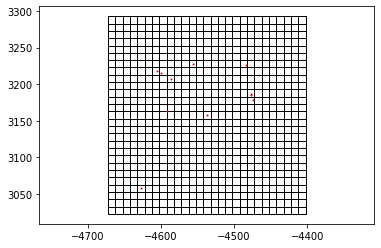

In [167]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


ppartP, lbx, lby = rangeAABB(p[123])

rt = []

for i in range(27):
    for j in range(27):
        rt.append(Rectangle((lbx+i*step, lby+j*step),10,10))

pc = PatchCollection(rt,facecolors='w', alpha=1,
                         edgecolor='k')

print(len(rt)) 


fig, ax = plt.subplots(1)
ax.add_collection(pc)


x = np.array([q.x for q in ppartP])
y = np.array([q.y for q in ppartP])
ax.scatter(x, y, s=1, c='r')
ax.axis("equal")

plt.show()

### 生成训练数据X

In [241]:
from time import time
cntImgs = 0
mapCSV = []
data = np.zeros((1, x_size, x_size, 3))
size = x_size
pathname = 'X_270_270'

flag = True


lastTime = time()
for q in p:
    if(cntImgs > 15):
        break
    cntImgs += 1
    ppartP, lbx, lby = rangeAABB(q, size/2)
    if(len(ppartP) == 1):
        continue
    
    arr = drawAABB(ppartP, lbx, lby, size, pathname)
    if(flag): 
        data = arr[np.newaxis, :]
        flag = False
    else:
        data = np.concatenate([data, arr[np.newaxis, :]])
    # print(arr.shape)
    # plt.imshow(arr)
    if(cntImgs % 10 == 0):
        print("Progress...{}/{}, {} seconds".format(cntImgs, len(p), time()-lastTime))
        lastTime = time()

np.save('./data/{}.npy'.format(pathname), data)
print("Total Len", len(p))
print("Finish filter...Data size = ", data.shape[0])

import csv
with open('./data/{}.csv'.format(pathname), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['id', 'filename'])
    writer.writerows(mapCSV)


In [0]:
b = np.load('./data/X_270_270.npy')
print(b.shape)
plt.imshow(b[2, :].reshape(270, 270, 3))

### 生成训练数据Y

In [0]:
index = []
with open('./data/X_270_270.csv','r') as csvfile:
    rows=csv.reader(csvfile)
    headers = next(rows)
    for row in rows:
        index.append(int(row[0]))

print(index)


In [0]:
from time import time
cntImgs = 0
mapCSV = []
data = np.zeros((1, x_size, x_size, 3))
size = y_size
pathname = 'Y_90_90'

flag = True



lastTime = time()
for id in index:
    q = p[id]

    if(cntImgs > 15):
        break
    cntImgs = id
    ppartP, lbx, lby = rangeAABB(q, size/2)
    
    arr = drawAABB(ppartP, lbx, lby, size, pathname)
    if(flag): 
        data = arr[np.newaxis, :]
        flag = False
    else:
        data = np.concatenate([data, arr[np.newaxis, :]])
    # print(arr.shape)
    # plt.imshow(arr)
    if(cntImgs % 10 == 0):
        print("Progress...{}/{}, {} seconds".format(cntImgs, len(p), time()-lastTime))
        lastTime = time()

np.save('./data/{}.npy'.format(pathname), data)
print("Total Len", len(p))
print("Finish filter...Data size = ", data.shape[0])

import csv
with open('./data/{}.csv'.format(pathname), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['id', 'filename'])
    writer.writerows(mapCSV)
